In [30]:
# libraries
import mne
import glob
%matplotlib widget
from os import chdir, makedirs
from os.path import join
import matplotlib.pyplot as plt ## for basic plotting
import matplotlib as mpl ## for setting default parameters
import pandas as pd
import numpy as np

In [17]:
# paths
subject = '0169'
workshop_date = '20250923'
MEG_path = f"/work/MEG_data/workshop_data/{subject}/{workshop_date}_000000" ## you can pick your study group member
subjects_dir = '/work/freesurfer'
behaviour_path = '/work/MEG_data/workshop_data/behavioural_logs'

In [18]:
# load MEG data
raw = mne.io.read_raw_fif(join(MEG_path, 'workshop_2025_raw.fif'), preload=True) 
#fig = raw.plot()

# load behavioral data
files = glob.glob(f"{behaviour_path}/{subject}*_experiment_data.csv") # match any file that starts with subject number
if files:
    behaviour = pd.read_csv(files[0], index_col=False)
else:
    print("No matching files found")

Opening raw data file /work/MEG_data/workshop_data/0169/20250923_000000/workshop_2025_raw.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-06 (1 x 102)  idle
    Range : 2024000 ... 3601999 =   2024.000 ...  3601.999 secs
Ready.
Reading 0 ... 1577999  =      0.000 ...  1577.999 secs...


In [19]:
# reject bad channels
raw.info['bads'] = ['EOG002']  # mark channels as bad

In [20]:
# filter by frequency
raw.filter(h_freq=40, l_freq=1) # band pass

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



<Raw | workshop_2025_raw.fif, 313 x 1578000 (1578.0 s), ~3.69 GiB, data loaded>

In [21]:
# find events
events = mne.find_events(raw)

# identify event indices where stimulus is shown (event code 1 and 3)
target_indices = events[ : , 2] < 4

# rename those events by a code indicating their following PAS score
events[target_indices, 2] = behaviour['subjective_response'] + 20

#behaviour['subjective_response'].value_counts()

Finding events on: STI101
1600 events found on stim channel STI101
Event IDs: [ 1  3  4  6  8 10 12 14 16]


In [22]:
# prepare dict with event names
event_id = dict(NE=21, WG=22, ACE=23, CE=24)

# creating epochs
epochs = mne.Epochs(raw,
                    events,
                    event_id = event_id,
                    tmin = -0.200,
                    tmax = 0.550,
                    baseline = (-0.200, 0),
                    preload = True)

epochs_eog_cleaned = mne.Epochs(raw,
                    events,
                    event_id = event_id,
                    tmin = -0.200,
                    tmax = 0.550,
                    baseline = (-0.200, 0),
                    reject = dict(eog=250e-6), # rejecting epochs with eog signal above 250 microvolt
                    preload = True) # telling it to apply the rejection

Not setting metadata


400 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
9 projection items activated
Using data from preloaded Raw for 400 events and 751 original time points ...
0 bad epochs dropped
Not setting metadata
400 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
9 projection items activated
Using data from preloaded Raw for 400 events and 751 original time points ...
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EO

In [23]:
epochs_eog_cleaned

<Epochs | 336 events (all good), -0.2 – 0.55 s (baseline -0.2 – 0 s), ~607.8 MiB, data loaded,
 'NE': 58
 'WG': 127
 'ACE': 94
 'CE': 57>

In [24]:
# creating averages (evoked responses) and difference waves
evokeds = list()
for event in epochs.event_id:
    evokeds.append(epochs[event].average())

evoked_diffs = list()
diffs_comment = ['CE - NE']
diffs = [(3,0)]
for diff in diffs:
    evoked_diff = evokeds[diff[0]].copy() # create a copy
    evoked_diff.data -= evokeds[diff[1]].data # modify the data in place
    evoked_diff.comment = diffs_comment
    evoked_diffs.append(evoked_diff)

# making another one without eog-rejected epochs
evokeds_filtered = list()
for event in epochs_eog_cleaned.event_id:
    evokeds_filtered.append(epochs_eog_cleaned[event].average())

evoked_filtered_diffs = list()
diffs_comment = ['CE - NE']
diffs = [(3,0)]
for diff in diffs:
    evoked_filtered_diff = evokeds_filtered[diff[0]].copy() # create a copy
    evoked_filtered_diff.data -= evokeds_filtered[diff[1]].data # modify the data in place
    evoked_filtered_diff.comment = diffs_comment
    evoked_filtered_diffs.append(evoked_filtered_diff)

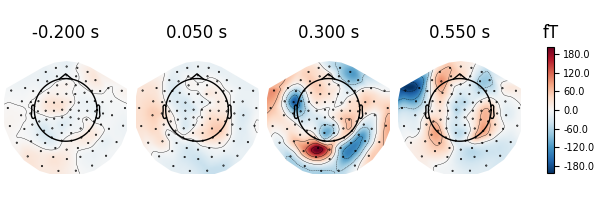

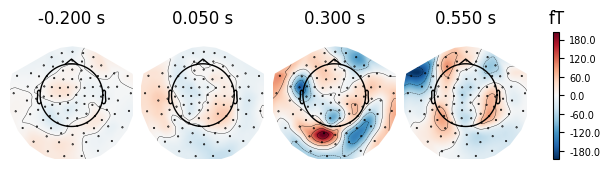

In [25]:
mne.viz.plot_evoked_topomap(evokeds[3])

In [26]:
# get forward model
info = evoked_filtered_diff.info
trans = join(MEG_path, 'workshop_2025-trans.fif')
src = join(subjects_dir, subject, 'bem', subject + '-oct-6-src.fif')
bem = join(subjects_dir, subject, 'bem', subject + '-5120-bem-sol.fif')

fwd = mne.make_forward_solution(
                            info, trans,
                            src, bem)

# save model
makedirs('models', exist_ok=True) # making sure folder exists
mne.write_forward_solution(f'models/{subject}-fwd.fif', fwd, overwrite=True)

Source space          : /work/freesurfer/0169/bem/0169-oct-6-src.fif
MRI -> head transform : /work/MEG_data/workshop_data/0169/20250923_000000/workshop_2025-trans.fif
Measurement data      : instance of Info
Conductor model   : /work/freesurfer/0169/bem/0169-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading /work/freesurfer/0169/bem/0169-oct-6-src.fif...
Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    0.999953 -0.002030 -0.009481      -0.95 mm
    0.005052 0.943696 0.330775      13.10 mm
    0.008275 -0.330807 0.943662      27.80 mm
    0.000000 0.000000 0.000000       1.00

Read 306 MEG channels from info
105 coil definitions read
Coordinate transformation: MEG device -> head
    0.994255 0.105501 0.018056       4.03 mm
    -0.105149 0.994267 -0.019438       1.63 mm
    -0.020003 0.017428 0.999648      62.97 mm
    0.000000 0.000000 0.000000       1.0

In [27]:
# load saved model
#fwd = mne.read_forward_solution(f'models/{subject}-fwd.fif')